# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

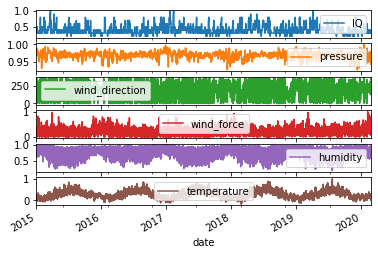

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.5,0.988013,0.126316,1.00,-0.007246,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,0.5,0.986958,0.184211,0.95,-0.009662,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 06:00:00+00:00,0.5,0.987629,0.178947,0.94,-0.012077,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,0.5,0.987821,0.247368,0.85,0.028986,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00+00:00,0.5,0.985999,0.336842,0.72,0.099034,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
features = pd.concat([features, pd.get_dummies(features['wind_direction'])], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 16 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (1881, 16, 42)
y_train : (1881, 3, 1)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input
from keras.models import save_model

In [9]:
OPTIMIZER = RMSprop(0.0005)

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = LSTM(512,input_shape=input_shape,name='LSTM_layer')(inp)
    _ = Dense(128,name="Intermediate_dense_layer")(_)
    
    outD1 = Dense(1,name="D1")(_)
    outD2 = Dense(1,name="D2")(_)
    outD3 = Dense(1,name="D3")(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])
    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'mse', 'D2': 'mse', 'D3': 'mse'}, metrics={'D1': 'mae', 'D2': 'mae', 'D3': 'mae'})
    model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 42)       0                                            
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 512)          1136640     input_1[0][0]                    
__________________________________________________________________________________________________
Intermediate_dense_layer (Dense (None, 128)          65664       LSTM_layer[0][0]                 
__________________________________________________________________________________________________
D1 (Dense)                      (None, 1)            129         Intermediate_dense_layer[0][0]   
__________________________________________________________________________________________________
D2 (De

### Train

In [10]:
EPOCHS = 40
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board])
    save_model(model,"Models/model"+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1504 samples, validate on 377 samples


Epoch 1/40
1504/1504 [==============================] - 6s 4ms/step - loss: 0.0873 - D1_loss: 0.0233 - D2_loss: 0.0344 - D3_loss: 0.0296 - D1_mean_absolute_error: 0.1178 - D2_mean_absolute_error: 0.1327 - D3_mean_absolute_error: 0.1285 - val_loss: 0.0607 - val_D1_loss: 0.0193 - val_D2_loss: 0.0238 - val_D3_loss: 0.0176 - val_D1_mean_absolute_error: 0.1027 - val_D2_mean_absolute_error: 0.1316 - val_D3_mean_absolute_error: 0.1009
Epoch 2/40
1504/1504 [==============================] - 6s 4ms/step - loss: 0.0571 - D1_loss: 0.0166 - D2_loss: 0.0202 - D3_loss: 0.0204 - D1_mean_absolute_error: 0.0975 - D2_mean_absolute_error: 0.1098 - D3_mean_absolute_error: 0.1087 - val_loss: 0.0510 - val_D1_loss: 0.0156 - val_D2_loss: 0.0177 - val_D3_loss: 0.0177 - val_D1_mean_absolute_error: 0.0985 - val_D2_mean_absolute_error: 0.0976 - val_D3_mean_absolute_error

1504/1504 [==============================] - 11s 7ms/step - loss: 0.0376 - D1_loss: 0.0095 - D2_loss: 0.0132 - D3_loss: 0.0150 - D1_mean_absolute_error: 0.0737 - D2_mean_absolute_error: 0.0871 - D3_mean_absolute_error: 0.0937 - val_loss: 0.0519 - val_D1_loss: 0.0128 - val_D2_loss: 0.0192 - val_D3_loss: 0.0199 - val_D1_mean_absolute_error: 0.0845 - val_D2_mean_absolute_error: 0.0994 - val_D3_mean_absolute_error: 0.1000
Epoch 18/40
1504/1504 [==============================] - 6s 4ms/step - loss: 0.0374 - D1_loss: 0.0100 - D2_loss: 0.0130 - D3_loss: 0.0144 - D1_mean_absolute_error: 0.0754 - D2_mean_absolute_error: 0.0875 - D3_mean_absolute_error: 0.0905 - val_loss: 0.0532 - val_D1_loss: 0.0137 - val_D2_loss: 0.0199 - val_D3_loss: 0.0196 - val_D1_mean_absolute_error: 0.0847 - val_D2_mean_absolute_error: 0.0997 - val_D3_mean_absolute_error: 0.1024
Epoch 19/40
1504/1504 [==============================] - 4s 3ms/step - loss: 0.0375 - D1_loss: 0.0096 - D2_loss: 0.0132 - D3_loss: 0.0147 - D1_me

Epoch 36/40
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0275 - D1_loss: 0.0071 - D2_loss: 0.0092 - D3_loss: 0.0112 - D1_mean_absolute_error: 0.0644 - D2_mean_absolute_error: 0.0737 - D3_mean_absolute_error: 0.0807 - val_loss: 0.0560 - val_D1_loss: 0.0133 - val_D2_loss: 0.0205 - val_D3_loss: 0.0222 - val_D1_mean_absolute_error: 0.0861 - val_D2_mean_absolute_error: 0.1056 - val_D3_mean_absolute_error: 0.1159
Epoch 37/40
1504/1504 [==============================] - 4s 3ms/step - loss: 0.0271 - D1_loss: 0.0071 - D2_loss: 0.0090 - D3_loss: 0.0111 - D1_mean_absolute_error: 0.0650 - D2_mean_absolute_error: 0.0731 - D3_mean_absolute_error: 0.0802 - val_loss: 0.0620 - val_D1_loss: 0.0147 - val_D2_loss: 0.0239 - val_D3_loss: 0.0234 - val_D1_mean_absolute_error: 0.0870 - val_D2_mean_absolute_error: 0.1095 - val_D3_mean_absolute_error: 0.1132
Epoch 38/40
1504/1504 [==============================] - 6s 4ms/step - loss: 0.0262 - D1_loss: 0.0070 - D2_loss: 0.0085 - D3_loss: 0.0

Epoch 15/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0201 - D1_loss: 0.0065 - D2_loss: 0.0066 - D3_loss: 0.0070 - D1_mean_absolute_error: 0.0605 - D2_mean_absolute_error: 0.0621 - D3_mean_absolute_error: 0.0637 - val_loss: 0.0445 - val_D1_loss: 0.0111 - val_D2_loss: 0.0137 - val_D3_loss: 0.0197 - val_D1_mean_absolute_error: 0.0806 - val_D2_mean_absolute_error: 0.0900 - val_D3_mean_absolute_error: 0.1100
Epoch 16/40
1505/1505 [==============================] - 4s 3ms/step - loss: 0.0192 - D1_loss: 0.0054 - D2_loss: 0.0062 - D3_loss: 0.0075 - D1_mean_absolute_error: 0.0569 - D2_mean_absolute_error: 0.0605 - D3_mean_absolute_error: 0.0665 - val_loss: 0.0447 - val_D1_loss: 0.0160 - val_D2_loss: 0.0123 - val_D3_loss: 0.0164 - val_D1_mean_absolute_error: 0.1051 - val_D2_mean_absolute_error: 0.0848 - val_D3_mean_absolute_error: 0.0977
Epoch 17/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0181 - D1_loss: 0.0057 - D2_loss: 0.0058 - D3_loss: 0.0

Epoch 34/40
1505/1505 [==============================] - 4s 3ms/step - loss: 0.0112 - D1_loss: 0.0041 - D2_loss: 0.0035 - D3_loss: 0.0036 - D1_mean_absolute_error: 0.0496 - D2_mean_absolute_error: 0.0451 - D3_mean_absolute_error: 0.0458 - val_loss: 0.0481 - val_D1_loss: 0.0115 - val_D2_loss: 0.0159 - val_D3_loss: 0.0208 - val_D1_mean_absolute_error: 0.0844 - val_D2_mean_absolute_error: 0.0957 - val_D3_mean_absolute_error: 0.1089
Epoch 35/40
1505/1505 [==============================] - 4s 3ms/step - loss: 0.0103 - D1_loss: 0.0034 - D2_loss: 0.0031 - D3_loss: 0.0038 - D1_mean_absolute_error: 0.0452 - D2_mean_absolute_error: 0.0437 - D3_mean_absolute_error: 0.0470 - val_loss: 0.0889 - val_D1_loss: 0.0510 - val_D2_loss: 0.0170 - val_D3_loss: 0.0209 - val_D1_mean_absolute_error: 0.1492 - val_D2_mean_absolute_error: 0.0960 - val_D3_mean_absolute_error: 0.1089
Epoch 36/40
1505/1505 [==============================] - 4s 3ms/step - loss: 0.0106 - D1_loss: 0.0040 - D2_loss: 0.0031 - D3_loss: 0.0

Epoch 13/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0082 - D1_loss: 0.0027 - D2_loss: 0.0026 - D3_loss: 0.0028 - D1_mean_absolute_error: 0.0405 - D2_mean_absolute_error: 0.0399 - D3_mean_absolute_error: 0.0414 - val_loss: 0.0231 - val_D1_loss: 0.0136 - val_D2_loss: 0.0044 - val_D3_loss: 0.0050 - val_D1_mean_absolute_error: 0.0923 - val_D2_mean_absolute_error: 0.0537 - val_D3_mean_absolute_error: 0.0551
Epoch 14/40
1505/1505 [==============================] - 6s 4ms/step - loss: 0.0081 - D1_loss: 0.0032 - D2_loss: 0.0023 - D3_loss: 0.0026 - D1_mean_absolute_error: 0.0428 - D2_mean_absolute_error: 0.0369 - D3_mean_absolute_error: 0.0387 - val_loss: 0.0143 - val_D1_loss: 0.0043 - val_D2_loss: 0.0047 - val_D3_loss: 0.0054 - val_D1_mean_absolute_error: 0.0533 - val_D2_mean_absolute_error: 0.0550 - val_D3_mean_absolute_error: 0.0577
Epoch 15/40
1505/1505 [==============================] - 4s 3ms/step - loss: 0.0072 - D1_loss: 0.0025 - D2_loss: 0.0022 - D3_loss: 0.0

Epoch 32/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0046 - D1_loss: 0.0016 - D2_loss: 0.0013 - D3_loss: 0.0017 - D1_mean_absolute_error: 0.0305 - D2_mean_absolute_error: 0.0276 - D3_mean_absolute_error: 0.0305 - val_loss: 0.0277 - val_D1_loss: 0.0150 - val_D2_loss: 0.0063 - val_D3_loss: 0.0064 - val_D1_mean_absolute_error: 0.1023 - val_D2_mean_absolute_error: 0.0637 - val_D3_mean_absolute_error: 0.0615
Epoch 33/40
1505/1505 [==============================] - 4s 3ms/step - loss: 0.0045 - D1_loss: 0.0017 - D2_loss: 0.0015 - D3_loss: 0.0014 - D1_mean_absolute_error: 0.0316 - D2_mean_absolute_error: 0.0294 - D3_mean_absolute_error: 0.0287 - val_loss: 0.0263 - val_D1_loss: 0.0095 - val_D2_loss: 0.0105 - val_D3_loss: 0.0063 - val_D1_mean_absolute_error: 0.0744 - val_D2_mean_absolute_error: 0.0832 - val_D3_mean_absolute_error: 0.0629
Epoch 34/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0041 - D1_loss: 0.0014 - D2_loss: 0.0014 - D3_loss: 0.0

Epoch 11/40
1505/1505 [==============================] - 6s 4ms/step - loss: 0.0035 - D1_loss: 0.0011 - D2_loss: 0.0012 - D3_loss: 0.0012 - D1_mean_absolute_error: 0.0265 - D2_mean_absolute_error: 0.0269 - D3_mean_absolute_error: 0.0264 - val_loss: 0.0157 - val_D1_loss: 0.0077 - val_D2_loss: 0.0038 - val_D3_loss: 0.0041 - val_D1_mean_absolute_error: 0.0674 - val_D2_mean_absolute_error: 0.0473 - val_D3_mean_absolute_error: 0.0492
Epoch 12/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0039 - D1_loss: 0.0014 - D2_loss: 0.0012 - D3_loss: 0.0012 - D1_mean_absolute_error: 0.0280 - D2_mean_absolute_error: 0.0267 - D3_mean_absolute_error: 0.0263 - val_loss: 0.0102 - val_D1_loss: 0.0058 - val_D2_loss: 0.0019 - val_D3_loss: 0.0025 - val_D1_mean_absolute_error: 0.0593 - val_D2_mean_absolute_error: 0.0349 - val_D3_mean_absolute_error: 0.0402
Epoch 13/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0035 - D1_loss: 0.0013 - D2_loss: 0.0011 - D3_loss: 0.0

Epoch 30/40
1505/1505 [==============================] - 7s 5ms/step - loss: 0.0025 - D1_loss: 9.8811e-04 - D2_loss: 7.2215e-04 - D3_loss: 7.6281e-04 - D1_mean_absolute_error: 0.0227 - D2_mean_absolute_error: 0.0202 - D3_mean_absolute_error: 0.0207 - val_loss: 0.0099 - val_D1_loss: 0.0038 - val_D2_loss: 0.0034 - val_D3_loss: 0.0027 - val_D1_mean_absolute_error: 0.0490 - val_D2_mean_absolute_error: 0.0460 - val_D3_mean_absolute_error: 0.0401
Epoch 31/40
1505/1505 [==============================] - 8s 5ms/step - loss: 0.0023 - D1_loss: 8.5130e-04 - D2_loss: 7.1072e-04 - D3_loss: 7.0479e-04 - D1_mean_absolute_error: 0.0220 - D2_mean_absolute_error: 0.0207 - D3_mean_absolute_error: 0.0206 - val_loss: 0.0178 - val_D1_loss: 0.0089 - val_D2_loss: 0.0051 - val_D3_loss: 0.0038 - val_D1_mean_absolute_error: 0.0699 - val_D2_mean_absolute_error: 0.0544 - val_D3_mean_absolute_error: 0.0483
Epoch 32/40
1505/1505 [==============================] - 6s 4ms/step - loss: 0.0031 - D1_loss: 0.0013 - D2_los

1505/1505 [==============================] - 5s 3ms/step - loss: 0.0020 - D1_loss: 5.7702e-04 - D2_loss: 7.2529e-04 - D3_loss: 7.1506e-04 - D1_mean_absolute_error: 0.0187 - D2_mean_absolute_error: 0.0205 - D3_mean_absolute_error: 0.0201 - val_loss: 0.0034 - val_D1_loss: 7.4926e-04 - val_D2_loss: 0.0013 - val_D3_loss: 0.0013 - val_D1_mean_absolute_error: 0.0216 - val_D2_mean_absolute_error: 0.0286 - val_D3_mean_absolute_error: 0.0291
Epoch 9/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0020 - D1_loss: 6.4420e-04 - D2_loss: 6.9119e-04 - D3_loss: 6.2202e-04 - D1_mean_absolute_error: 0.0200 - D2_mean_absolute_error: 0.0203 - D3_mean_absolute_error: 0.0193 - val_loss: 0.0042 - val_D1_loss: 0.0022 - val_D2_loss: 0.0011 - val_D3_loss: 8.3769e-04 - val_D1_mean_absolute_error: 0.0368 - val_D2_mean_absolute_error: 0.0273 - val_D3_mean_absolute_error: 0.0225
Epoch 10/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0021 - D1_loss: 7.6782e-04 - D2_loss

1505/1505 [==============================] - 5s 3ms/step - loss: 0.0017 - D1_loss: 5.6180e-04 - D2_loss: 5.1031e-04 - D3_loss: 6.3808e-04 - D1_mean_absolute_error: 0.0180 - D2_mean_absolute_error: 0.0173 - D3_mean_absolute_error: 0.0191 - val_loss: 0.0059 - val_D1_loss: 0.0016 - val_D2_loss: 0.0018 - val_D3_loss: 0.0024 - val_D1_mean_absolute_error: 0.0310 - val_D2_mean_absolute_error: 0.0350 - val_D3_mean_absolute_error: 0.0400
Epoch 27/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0016 - D1_loss: 5.9580e-04 - D2_loss: 4.9669e-04 - D3_loss: 5.4462e-04 - D1_mean_absolute_error: 0.0177 - D2_mean_absolute_error: 0.0169 - D3_mean_absolute_error: 0.0174 - val_loss: 0.0037 - val_D1_loss: 0.0010 - val_D2_loss: 0.0016 - val_D3_loss: 0.0010 - val_D1_mean_absolute_error: 0.0245 - val_D2_mean_absolute_error: 0.0321 - val_D3_mean_absolute_error: 0.0249
Epoch 28/40
1505/1505 [==============================] - 5s 3ms/step - loss: 0.0016 - D1_loss: 5.3219e-04 - D2_loss: 5.521

________________

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [12]:
y_pred = model.predict(x_train)

y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

Show the results in graphs:

Prediction of the air index quality


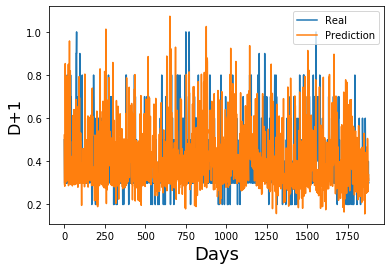

val_D1_loss 0.00113
val_D1_mean_absolute_error 0.02637
D1_loss 0.00043
D1_mean_absolute_error 0.01588


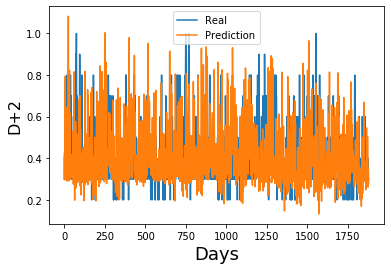

val_D2_loss 0.00199
val_D2_mean_absolute_error 0.03594
D2_loss 0.0005
D2_mean_absolute_error 0.01722


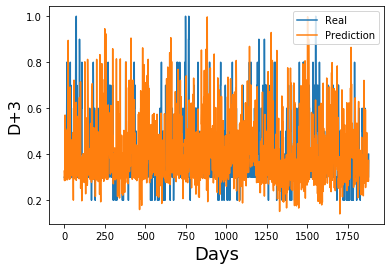

val_D3_loss 0.0023
val_D3_mean_absolute_error 0.03624
D3_loss 0.00047
D3_mean_absolute_error 0.01686


In [13]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))